# Import and Helper Functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import json

## Helper Function to load and manipulate data from files

In [2]:
min_value, max_value = 0, 100
def load_int_file(filename, min_val=min_value, max_val=max_value):
  with open(filename, 'r') as f:
    int_data = [float(line.strip()) for line in f if min_val <= float(line.strip()) <= max_val]

  return int_data

def load_itg_file(filename, min_val=min_value, max_val=max_value):
  with open(filename, 'r') as f:
    itg_data = json.load(f)
    itg_data = [value for value in itg_data if min_val <= value <= max_val]
  return itg_data

def load_owping_records(file_path, min_val=min_value, max_val=max_value):
  # Read the file and extract delay values
  delay_values = []
  with open(file_path, 'r') as file:
      for line in file:
          # Find the delay value after "delay=" in each line
          match = re.search(r'delay=([\d.]+)', line)
          if match and min_val <= float(match.group(1)) <= max_val:
              delay_values.append(float(match.group(1)))

  # Display the first few extracted delay values for verification
  return delay_values

def load_ping_records(file_path, min_val=min_value, max_val=max_value):
    rtt_values = []
    with open(file_path, 'r') as file:
        for line in file:
            # Find RTT value in the line
            match = re.search(r'time=([\d.]+) ms', line)
            if match and min_val <= float(match.group(1)) <= max_val:
                rtt_values.append(float(match.group(1)))
    return rtt_values

def calculate_statistics(data):
    np_data = np.array(data)  # Converte i dati in un numpy array per facilitare i calcoli

    statistics = {
        'min': round(np.min(np_data), 3),
        'max': round(np.max(np_data), 3),
        'mean': round(np.mean(np_data), 3),
        'median': round(np.median(np_data), 3),
        'std_dev': round(np.std(np_data), 3),
        'variance': round(np.var(np_data), 3),
    }
    return statistics

def extract_stats(data, sample_size):
  # Split data into chunks of `sample_size` and calculate statistics
    stats = []
    for i in range(0, len(data), sample_size):
        chunk = data[i:i + sample_size]
        if len(chunk) == sample_size:
            min_val = min(chunk)
            max_val = max(chunk)
            avg_val = sum(chunk) / len(chunk)
            std_dev = pd.Series(chunk).std()
            stats.append([min_val, max_val, avg_val, std_dev])

    # Create DataFrame
    df = pd.DataFrame(stats, columns=["Min", "Max", "Average", "Std Dev"])
    return df

def get_difference_mean(list1, list2):
    """
    Calculate the element-wise difference between two lists, and then compute the mean and variance.

    Parameters:
    list1 (list): The first list.
    list2 (list): The second list.

    Returns:
    tuple: A tuple containing the mean and variance of the differences.
    """
    if len(list1) != len(list2):
        raise ValueError("Both lists must have the same length.")
    # Calculate element-wise difference
    differences = np.array(list1) - np.array(list2)
    # Calculate mean and variance
    mean = round(np.mean(differences), 5)
    variance = round(np.std(differences), 5)
    return mean, variance




## Helper function to plot and visualize data (statistics)

In [3]:
def plot_curves_new(datasets, x_axys, filename, labels, colors, title='Comparison of OWD Measurements', xlabel='Simulation time [min]', ylabel='OWD [ms]', sinusoidal=False, n = 1):
  plt.figure(figsize=(10, 6))

  for data, label, color in zip(datasets, labels, colors):
      plt.plot(x_axys, data, label=label, color=color, linewidth=2)
  if title.split(" ")[0] == "TWD":
    ylabel = "TWD [ms]"
  if sinusoidal:
    # Generate the delay pattern curve
    pattern = [10, 15, 20, 25, 30, 30, 25, 20, 15, 10]
    if title.split(" ")[0] == "TWD":
      pattern = [20, 30, 40, 50, 60, 60, 50, 40, 30, 20]
    pattern_length = len(pattern)
    dotted_line = [value for value in pattern for _ in range(n)]

    dotted_line = dotted_line * (len(x_axys) // len(dotted_line)) + dotted_line[:len(x_axys) % len(dotted_line)]
    # Plot the dotted line following the sinusoidal pattern of delays
    plt.plot(x_axys, dotted_line, label='Pattern Line', color='black', linestyle=':', linewidth=1.5)

  plt.title(title, fontsize=16)
  plt.xlabel(xlabel, fontsize=14)
  plt.ylabel(ylabel, fontsize=14)
  plt.legend()
  plt.grid(True)
  plt.savefig(filename)
  plt.show()

def gen_boxplot(data, labels, limits, ylabel, title, filename="boxplot.png"):
    fig = plt.figure(figsize=(8,8))

    plt.title(title, fontsize = 14)
    plt.boxplot(data, labels=labels)
    plt.grid(visible=True)
    plt.ylim(limits)
    plt.ylabel(ylabel)

    plt.savefig(filename)
    plt.show()

def count_outliers(data):
    # Convert the data to a numpy array for ease of processing
    data = np.array(data)

    # Calculate the quartiles
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1

    # Define the outlier step
    outlier_step = 1.5 * iqr

    # Determine a list of indices of outliers for data
    outlier_indices = np.where((data < q1 - outlier_step) | (data > q3 + outlier_step))

    # Count the number of outliers
    num_outliers = len(outlier_indices[0])

    return num_outliers

def plot_histogram_with_mean_variance(data):
    # Calculate mean and variance
    mean = np.mean(data)
    variance = np.var(data)
    std_dev = np.sqrt(variance)

    # Create histogram
    plt.hist(data, bins='auto', color='blue', alpha=0.7)

    # Highlight the mean
    plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')

    # Highlight one standard deviation on either side of the mean
    plt.axvline(mean - std_dev, color='green', linestyle='dashed', linewidth=2, label=f'Mean - Std Dev: {mean - std_dev:.2f}')
    plt.axvline(mean + std_dev, color='green', linestyle='dashed', linewidth=2, label=f'Mean + Std Dev: {mean + std_dev:.2f}')

    # Adding labels and title
    plt.title('Histogram with Mean and Variance Highlighted')
    plt.xlabel('Data values')
    plt.ylabel('Frequency')
    plt.legend(fontsize='small')

    # Show plot
    plt.show()


### Packet Loss Helper Functions

In [4]:
folder = "/content/drive/MyDrive/Colab_Notebooks/Thesis/Data/PacketLoss/"
def extract_sequence_numbers(file_path):
    """
    Extract sequence numbers from each line in the file.

    Parameters:
    file_path (str): Path to the file containing the data.

    Returns:
    numpy.array: Array of sequence numbers extracted from the file.
    """

    # Regular expression to match the sequence number pattern
    pattern = r"Seq>\s+(\d+)"

    # List to store sequence numbers
    sequence_numbers = []
    lost_packets = []

    with open(file_path, 'r') as file:
        for line in file:
            # Search for the pattern in each line
            match = re.search(pattern, line)
            if match:
                # Extract and append the sequence number
                seq_num = int(match.group(1))
                sequence_numbers.append(seq_num)
    last = sequence_numbers[0]
    for i in sequence_numbers:
      if i - last > 1:
        lost_packets.append(i-1)
      last = i

    return np.array(lost_packets)

def load_json_file(file_path):
    """
    Load a JSON file and return its content.

    Parameters:
    file_path (str): Path to the JSON file.

    Returns:
    dict: The content of the JSON file.
    """
    try:
        with open(file_path, 'r') as file:
            data = json.load(file)
        return data
    except Exception as e:
        return f"An error occurred: {e}"

def load_lost_packets_file(filename):
  with open(filename, 'r') as f:
    data = [int(line.strip()) for line in f]

  return (data)

def dump_data_to_json(data, filename):
  """
  Write a list or array into a JSON file.

  Parameters:
  data (list or array): The data to be written into the file.
  filename (str): The name of the file to write the data to.

  Returns:
  None: The function writes to a file but does not return any value.
  """
  try:
      # Convert numpy arrays to list if necessary
      if isinstance(data, np.ndarray):
          data = data.tolist()
      # Write data to JSON file
      with open(filename, 'w') as file:
          json.dump(data, file)
  except Exception as e:
      print(f"An error occurred: {e}")

def resolve_modulo_sequence(data, modulo=2**16):
    resolved_seq_numbers = []
    offset = 0

    for i in range(len(data)):
        # If the sequence resets, increase the offset
        if i > 0 and data[i] < data[i - 1]:
            offset += modulo

        # Resolve the sequence number
        resolved_seq_numbers.append(data[i] + offset)
    print(len(resolved_seq_numbers))
    return resolved_seq_numbers

def count_lost_packets_in_segments(data, total_samples, segment_size):
    counts = [0] * (total_samples // segment_size)
    for packet in data:
        segment = packet // segment_size
        if segment < len(counts):
            counts[segment] += 1
    return counts

# One-Way Delay Data Visualization

## CPE-A -> CPE-B

### Fixed Delay
2 net int with 20ms delay

Load data from file

In [ ]:
data_folder = "/content/drive/MyDrive/Colab_Notebooks/Thesis/Data/FixedDelay/"

# Load data from JSON files
fixed_int_owd_ab = load_int_file(data_folder+"int_AtoB_owd_records.json", 15, 25)
fixed_itg_owd_ab = load_itg_file(data_folder+"itg_AtoB_owd_records.json", 0, 2000)
fixed_owping_owd_ab = load_owping_records(data_folder+'owping_AtoB_owd_records.txt', 10, 50)
print(len(fixed_int_owd_ab), len(fixed_itg_owd_ab), len(fixed_owping_owd_ab))
avg_to_append = np.mean(fixed_int_owd_ab)
for i in range(len(fixed_itg_owd_ab)-len(fixed_int_owd_ab)):
  fixed_int_owd_ab.append(avg_to_append)

avg_to_append = np.mean(fixed_owping_owd_ab)
for i in range(len(fixed_itg_owd_ab)-len(fixed_owping_owd_ab)):
  fixed_owping_owd_ab.append(avg_to_append)

print(len(fixed_int_owd_ab), len(fixed_itg_owd_ab), len(fixed_owping_owd_ab))


355760 360000 360000
360000 360000 360000


Extract Statistics from data and plot the curves

In [ ]:
sim_time_range = [1, 2, 5, 10]
for i in sim_time_range:
  sample_size = 100*60*i
  total_min = 60
  packet_rate = len(fixed_int_owd_ab)/(total_min*60)
  pack_to_time_factor = sample_size/packet_rate


  # Load data and compute statistics
  df_fixed_int_owd_ab = extract_stats(fixed_int_owd_ab, sample_size)
  df_fixed_itg_owd_ab = extract_stats(fixed_itg_owd_ab, sample_size)
  df_fixed_owping_owd_ab = extract_stats(fixed_owping_owd_ab, sample_size)

  time_seconds = np.array((df_fixed_int_owd_ab.index + 1) * pack_to_time_factor/60)
  time_seconds[0] = 0
  # Print DataFrames
  # print("INT Data Statistics:")
  # print(df_int)
  # print("\nITG Data Statistics:")
  # print(df_itg)
  # print("\nOWPing Data Statistics:")
  # print(df_owping)

  datasets = [df_fixed_int_owd_ab["Average"], df_fixed_itg_owd_ab["Average"], df_fixed_owping_owd_ab["Average"]]
  labels = ["INT", "ITG", "OWPing"]
  colors = ["red", "blue", "green"]

  import_data = pd.DataFrame({
      "INT": df_fixed_int_owd_ab["Average"],
      "ITG": df_fixed_itg_owd_ab["Average"],
      "OWPing": df_fixed_owping_owd_ab["Average"]
  })
  import_data.to_csv(data_folder+"Excel_Import/owd_AtoB_fixed_"+str(i)+"min.csv")

#   plot_curves_new(datasets=datasets, x_axys=time_seconds, filename=data_folder+"Plots/owd_AtoB_fixed_"+str(i)+"min.png", labels=labels, colors=colors, title='OWD A->B with fixed 20ms delay (avg every '+str(i)+' min)')

# limits = [np.min(datasets)-0.1, np.max(datasets)+0.1]
# gen_boxplot(datasets, labels, limits, "OWD [ms]", data_folder+"Plots/boxplot_owd_AtoB_fixed.png")
# for data in datasets:
#   print(count_outliers(data))

### Delay with Normal Distribution
2 net int with 20ms 5ms delay normal distribution

Load data from files

359989 359989


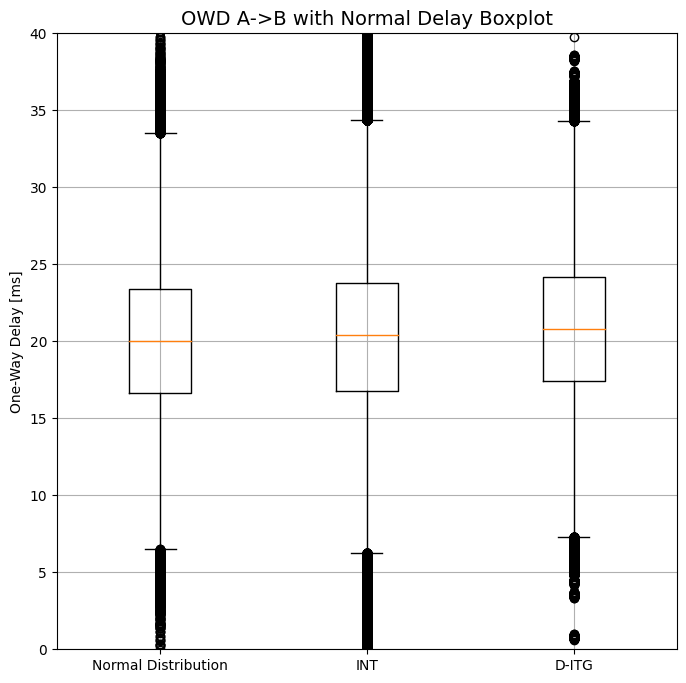

2496
17850
2516


In [ ]:
data_folder = "/content/drive/MyDrive/Colab_Notebooks/Thesis/Data/NormalDelay/"

# Load data from JSON files
normal_int_owd_ab = load_int_file(data_folder+"int_AtoB_owd_records.json", 0, 45)
normal_itg_owd_ab = load_itg_file(data_folder+"itg_AtoB_owd_records.json", 0, 45)

avg_to_append = np.mean(normal_int_owd_ab)
for i in range(len(normal_itg_owd_ab)-len(normal_int_owd_ab)):
  normal_int_owd_ab.append(avg_to_append)

print(len(normal_int_owd_ab), len(normal_itg_owd_ab))

data = np.random.normal(loc=20, scale=5, size=len(normal_int_owd_ab))
datasets = [data, normal_int_owd_ab, normal_itg_owd_ab]
limits = [0, 40]   #[np.min(datasets)-0.1, np.max(datasets)+0.1]
labels = ["Normal Distribution", "INT", "D-ITG"]
gen_boxplot(datasets, labels, limits, "One-Way Delay [ms]", "OWD A->B with Normal Delay Boxplot", data_folder+"Plots/boxplot_owd_AtoB_normal.png")
for data in datasets:
  print(count_outliers(data))


Extract Statistics from data and plot the curves

In [ ]:
sim_time_range = [1, 2, 5, 10]
for i in sim_time_range:
  sample_size = 100*60*i
  total_min = 60
  packet_rate = len(normal_int_owd_ab)/(total_min*60)
  pack_to_time_factor = sample_size/packet_rate


  # Load data and compute statistics
  df_normal_int_owd_ab = extract_stats(normal_int_owd_ab, sample_size)
  df_normal_itg_owd_ab = extract_stats(normal_itg_owd_ab, sample_size)

  time_seconds = np.array((df_normal_int_owd_ab.index + 1) * pack_to_time_factor/60)
  time_seconds[0] = 0
  # Print DataFrames
  # print("INT Data Statistics:")
  # print(df_int)
  # print("\nITG Data Statistics:")
  # print(df_itg)

  datasets = [df_normal_int_owd_ab["Average"], df_normal_itg_owd_ab["Average"]]
  labels = ["INT", "ITG"]
  colors = ["red", "blue"]


  import_data = pd.DataFrame({
      "INT": df_normal_int_owd_ab["Average"],
      "ITG": df_normal_itg_owd_ab["Average"]
  })
  #import_data.to_csv(data_folder+"Excel_Import/owd_AtoB_normal_"+str(i)+"min.csv")

#   plot_curves_new(datasets=datasets, x_axys=time_seconds, filename=data_folder+"Plots/owd_AtoB_normal_"+str(i)+"min.png", labels=labels, colors=colors, title='OWD A->B with normal delay (avg every '+str(i)+' min)')


### Delay with Sinusoidal Trend
2 net int following a delay pattern from a bash script

Load data from files

In [ ]:
data_folder = "/content/drive/MyDrive/Colab_Notebooks/Thesis/Data/SinusoidalDelay/"

sin_int_owd_ab = load_itg_file(data_folder+"int_AtoB_owd_records.json", 0, 200)
sin_itg_owd_ab = load_itg_file(data_folder+"itg_AtoB_owd_records.json", 0, 200)
sin_owping_owd_ab = load_owping_records(data_folder+'owping_AtoB_owd_records.txt', 0, 200)

print(len(sin_int_owd_ab), len(sin_itg_owd_ab), len(sin_owping_owd_ab))


360000 360000 360000


Extract Statistics from data and plot the curves

,Groundtruth,INT,ITG,OWPing
0,10,10.732000,10.931919,12.648300
1,15,15.890394,16.089770,17.588733
2,20,20.892699,21.092642,22.437450
3,25,25.965094,26.165589,27.393533
4,30,30.626536,30.827985,31.289300
5,30,30.108522,30.308987,30.191800
6,25,24.987824,25.188591,25.273450
7,20,19.897460,20.097057,20.205033
8,15,14.835864,15.035699,15.174867
9,10,10.581601,10.782738,11.178767


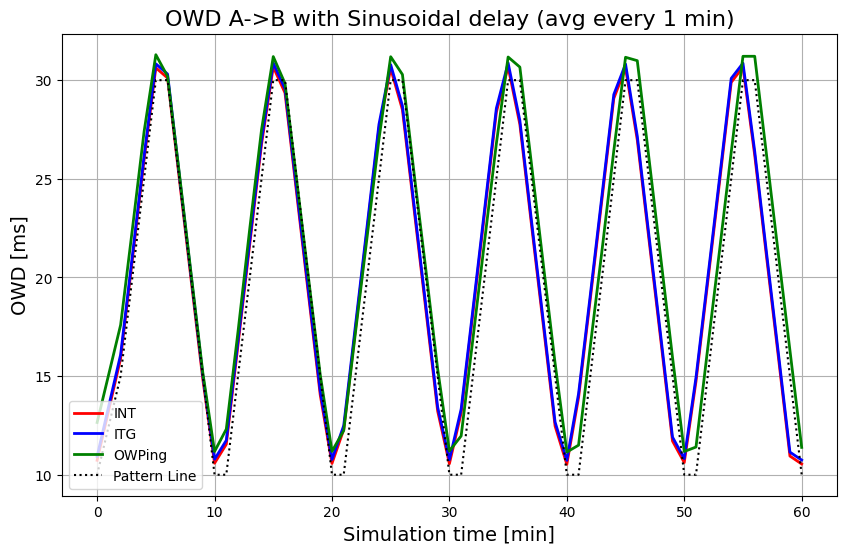

In [ ]:
sim_time_range = [1]
for i in sim_time_range:
  sample_size = 100*60*i
  total_min = 60
  packet_rate = len(sin_int_owd_ab)/(total_min*60)
  pack_to_time_factor = sample_size/packet_rate

  pattern = [10, 15, 20, 25, 30, 30, 25, 20, 15, 10]
  pattern_length = len(pattern)
  dotted_line = [value for value in pattern for _ in range(1)]
  dotted_line = dotted_line * (len(time_seconds) // len(dotted_line)) + dotted_line[:len(time_seconds) % len(dotted_line)]

  # Load data and compute statistics
  df_sin_int_owd_ab = extract_stats(sin_int_owd_ab, sample_size)
  df_sin_itg_owd_ab = extract_stats(sin_itg_owd_ab, sample_size)
  df_sin_owping_owd_ab = extract_stats(sin_owping_owd_ab, sample_size)

  time_seconds = np.array((df_sin_itg_owd_ab.index + 1) * pack_to_time_factor/60)
  time_seconds[0] = 0

  datasets = [df_sin_int_owd_ab["Average"], df_sin_itg_owd_ab["Average"], df_sin_owping_owd_ab["Average"]]
  labels = ["INT", "ITG", "OWPing"]
  colors = ["red", "blue", "green"]


  import_data = pd.DataFrame({
      "Groundtruth": dotted_line,
      "INT": df_sin_int_owd_ab["Average"],
      "ITG": df_sin_itg_owd_ab["Average"],
      "OWPing": df_sin_owping_owd_ab["Average"]
  })
  display(import_data)
  #import_data.to_csv(data_folder+"Excel_Import/owd_AtoB_sin_"+str(i)+"min.csv")

  plot_curves_new(datasets=datasets, x_axys=time_seconds, filename=data_folder+"Plots/owd_AtoB_sin_"+str(i)+"min.png", labels=labels, colors=colors, title='OWD A->B with Sinusoidal delay (avg every '+str(i)+' min)', sinusoidal=True, n=1)



## CPE-B -> CPE-A

### Fixed Delay
2 net int with 20ms delay

Load data from file

In [ ]:
data_folder = "/content/drive/MyDrive/Colab_Notebooks/Thesis/Data/FixedDelay/"

# Load data from files
fix_int_owd_ba = load_int_file(data_folder+"int_BtoA_owd_records.json", 10, 50)

fix_itg_owd_ba = load_itg_file(data_folder+"itg_BtoA_owd_records.json", 0, 200)

fix_owping_owd_ba = load_owping_records(data_folder+'owping_BtoA_owd_records.txt', 10, 50)

avg_to_append = np.mean(fix_int_owd_ba)
for i in range(len(fix_itg_owd_ba)-len(fix_int_owd_ba)):
  fix_int_owd_ba.append(avg_to_append)

avg_to_append = np.mean(fix_owping_owd_ba)
for i in range(len(fix_itg_owd_ba)-len(fix_owping_owd_ba)):
  fix_owping_owd_ba.append(avg_to_append)

print(len(fix_int_owd_ba), len(fix_itg_owd_ba), len(fix_owping_owd_ba))


360000 360000 360000


Extract Statistics from data and plot the curves

In [ ]:
sim_time_range = [1, 2, 5, 10]
for i in sim_time_range:
  sample_size = 100*60*i
  total_min = 60
  packet_rate = len(fixed_int_owd_ab)/(total_min*60)
  pack_to_time_factor = sample_size/packet_rate

  # Load data and compute statistics
  df_fix_int_owd_ba = extract_stats(fix_int_owd_ba, sample_size)
  df_fix_itg_owd_ba = extract_stats(fix_itg_owd_ba, sample_size)
  df_fix_owping_owd_ba = extract_stats(fix_owping_owd_ba, sample_size)


  time_seconds = np.array((df_fix_itg_owd_ba.index + 1) * pack_to_time_factor/60)
  time_seconds[0] = 0
  # Print DataFrames
  # print("INT Data Statistics:")
  # print(df_fixed_int_owd_ba)
  # print("\nITG Data Statistics:")
  # print(df_fixed_itg_owd_ba)
  # print("\nOWPing Data Statistics:")
  # print(df_fixed_owping_owd_ba)

  datasets = [df_fix_int_owd_ba["Average"], df_fix_itg_owd_ba["Average"], df_fix_owping_owd_ba["Average"]]
  labels = ["INT", "ITG", "OWPing"]
  colors = ["red", "blue", "green"]


  import_data = pd.DataFrame({
      "INT": df_fix_int_owd_ba["Average"],
      "ITG": df_fix_itg_owd_ba["Average"],
      "OWPing": df_fix_owping_owd_ba["Average"]
  })
  import_data.to_csv(data_folder+"Excel_Import/owd_BtoA_fixed_"+str(i)+"min.csv")

#   plot_curves_new(datasets=datasets, x_axys=time_seconds, filename=data_folder+"Plots/owd_BtoA_fixed_"+str(i)+"min.png", labels=labels, colors=colors, title='OWD B->A with Fixed delay (avg every '+str(i)+' min)')

# limits = [np.min(datasets)-0.1, np.max(datasets)+0.1]
# gen_boxplot(datasets, labels, limits, "OWD [ms]", data_folder+"Plots/boxplot_owd_BtoA_fixed.png")
# for data in datasets:
#   print(count_outliers(data))

### Delay with Normal Distribution
2 net int with 20ms 5ms delay normal distribution

Load data from files

360000 360000


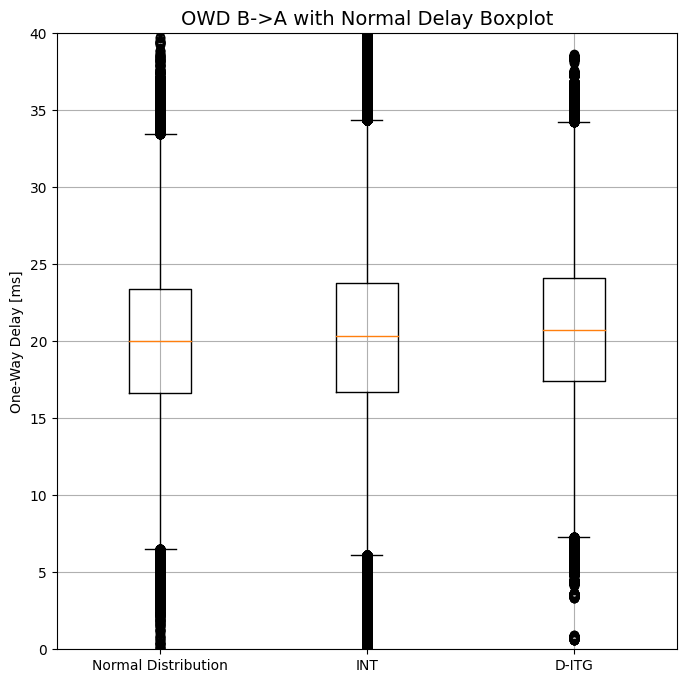

2648
17460
2544


In [ ]:
data_folder = "/content/drive/MyDrive/Colab_Notebooks/Thesis/Data/NormalDelay/"

# Load data from files
normal_int_owd_ba = load_int_file(data_folder+"int_BtoA_owd_records.json", 0, 50)

normal_itg_owd_ba = load_itg_file(data_folder+"itg_BtoA_owd_records.json", 0, 50)

avg_to_append = np.mean(normal_int_owd_ba)
for i in range(len(normal_itg_owd_ba)-len(normal_int_owd_ba)):
  normal_int_owd_ba.append(avg_to_append)

print(len(normal_int_owd_ba), len(normal_itg_owd_ba))

data = np.random.normal(loc=20, scale=5, size=len(normal_int_owd_ba))
datasets = [data, normal_int_owd_ba, normal_itg_owd_ba]
limits = [0, 40]   #[np.min(datasets)-0.1, np.max(datasets)+0.1]
labels = ["Normal Distribution", "INT", "D-ITG"]
gen_boxplot(datasets, labels, limits, "One-Way Delay [ms]", "OWD B->A with Normal Delay Boxplot", data_folder+"Plots/boxplot_owd_BtoA_normal.png")
for data in datasets:
  print(count_outliers(data))

Extract Statistics from data and plot the curves

In [ ]:
sim_time_range = [1, 2, 5, 10]
for i in sim_time_range:
  sample_size = 100*60*i
  total_min = 60
  packet_rate = len(normal_int_owd_ab)/(total_min*60)
  pack_to_time_factor = sample_size/packet_rate

  # Load data and compute statistics
  df_normal_int_owd_ba = extract_stats(normal_int_owd_ba, sample_size)
  df_normal_itg_owd_ba = extract_stats(normal_itg_owd_ba, sample_size)

  time_seconds = np.array((df_normal_itg_owd_ba.index + 1) * pack_to_time_factor/60)
  time_seconds[0] = 0
  # Print DataFrames
  # print("INT Data Statistics:")
  # print(df_normal_int_owd_ba)
  # print("\nITG Data Statistics:")
  # print(df_normal_itg_owd_ba)
  # print("\nOWPing Data Statistics:")
  # print(df_normal_owping_owd_ba)

  datasets = [df_normal_int_owd_ba["Average"], df_normal_itg_owd_ba["Average"]]
  labels = ["INT", "ITG"]
  colors = ["red", "blue"]


  import_data = pd.DataFrame({
      "INT": df_normal_int_owd_ba["Average"],
      "ITG": df_normal_itg_owd_ba["Average"]
  })
  import_data.to_csv(data_folder+"Excel_Import/owd_BtoA_normal_"+str(i)+"min.csv")

#   plot_curves_new(datasets=datasets, x_axys=time_seconds, filename=data_folder+"Plots/owd_BtoA_normal_"+str(i)+"min.png", labels=labels, colors=colors, title='OWD B->A with Normal delay (avg every '+str(i)+' min)')

# limits = [np.min(datasets)-0.1, np.max(datasets)+0.1]
# gen_boxplot(datasets, labels, limits, "OWD [ms]", data_folder+"Plots/boxplot_owd_BtoA_normal.png")
# for data in datasets:
#   print(count_outliers(data))

### Delay with Sinusoidal Trend
2 net int following a delay pattern from a bash script

Load data from files

In [ ]:
data_folder = "/content/drive/MyDrive/Colab_Notebooks/Thesis/Data/SinusoidalDelay/"

# Load data from files
sin_int_owd_ba = load_int_file(data_folder+"int_BtoA_owd_records.json", 0, 50)
sin_itg_owd_ba = load_itg_file(data_folder+"itg_BtoA_owd_records.json", 0, 2000)
sin_owping_owd_ba = load_owping_records(data_folder+'owping_BtoA_owd_records.txt', 0, 2000)

avg_to_append = np.mean(sin_int_owd_ba)
for i in range(len(sin_itg_owd_ba)-len(sin_int_owd_ba)):
  sin_int_owd_ba.append(avg_to_append)

print(len(sin_int_owd_ba), len(sin_itg_owd_ba), len(sin_owping_owd_ba))

360000 360000 360000


Extract Statistics from data and plot the curves

In [ ]:
sim_time_range = [1]
for i in sim_time_range:
  sample_size = 100*60*i
  total_min = 60
  packet_rate = len(sin_int_owd_ba)/(total_min*60)
  pack_to_time_factor = sample_size/packet_rate

  pattern = [10, 15, 20, 25, 30, 30, 25, 20, 15, 10]
  pattern_length = len(pattern)
  dotted_line = [value for value in pattern for _ in range(6)]
  dotted_line = dotted_line * (len(time_seconds) // len(dotted_line)) + dotted_line[:len(time_seconds) % len(dotted_line)]

  # Load data and compute statistics
  df_sin_int_owd_ba = extract_stats(sin_int_owd_ba, sample_size)
  df_sin_itg_owd_ba = extract_stats(sin_itg_owd_ba, sample_size)
  df_sin_owping_owd_ba = extract_stats(sin_owping_owd_ba, sample_size)

  time_seconds = np.array((df_sin_itg_owd_ba.index + 1) * pack_to_time_factor/60)
  time_seconds[0] = 0

  datasets = [df_sin_int_owd_ba["Average"], df_sin_itg_owd_ba["Average"], df_sin_owping_owd_ba["Average"]]
  labels = ["INT", "ITG", "OWPing"]
  colors = ["red", "blue", "green"]

  import_data = pd.DataFrame({
      "Groundtruth": dotted_line,
      "INT": df_sin_int_owd_ba["Average"],
      "ITG": df_sin_itg_owd_ba["Average"],
      "OWPing": df_sin_owping_owd_ba["Average"]
  })
  import_data.to_csv(data_folder+"Excel_Import/owd_BtoA_sin_"+str(i)+"min.csv")

#   plot_curves_new(datasets=datasets, x_axys=time_seconds, filename=data_folder+"Plots/owd_BtoA_sin_"+str(i)+"min.png", labels=labels, colors=colors, title='OWD B->A with Sinusoidal delay (avg every '+str(i)+' min)', sinusoidal=True, n=6)

# limits = [np.min(datasets)-0.1, np.max(datasets)+0.1]
# gen_boxplot(datasets, labels, limits, "OWD [ms]", data_folder+"Plots/boxplot_owd_BtoA_sin.png")
# for data in datasets:
#   print(count_outliers(data))

# Two-Way Delay

## Fixed Delay

Load Two-Way Delay Datasets from files

In [ ]:
data_folder = "/content/drive/MyDrive/Colab_Notebooks/Thesis/Data/FixedDelay/"

# Load data from JSON files
fixed_int_twd = load_int_file(data_folder+"int_twd_records.json", 35, 45)
fixed_itg_twd = load_itg_file(data_folder+"itg_twd_records.json", 0, 50)
fixed_ping_twd = load_ping_records(data_folder+'ping_twd_records.txt', 10, 50)

avg_to_append = np.mean(fixed_int_twd)
for i in range(len(fixed_itg_twd)-len(fixed_int_twd)):
  fixed_int_twd.append(avg_to_append)

avg_to_append = np.mean(fixed_ping_twd)
for i in range(len(fixed_itg_twd)-len(fixed_ping_twd)):
  fixed_ping_twd.append(avg_to_append)

print(len(fixed_int_twd), len(fixed_itg_twd), len(fixed_ping_twd))


143505
144000 144000 144000


Extract Statistics from Datasets and generate plots

In [ ]:
sim_time_range = [1, 2, 5, 10]
for i in sim_time_range:
  sample_size = 20*60*i
  total_min = 120
  packet_rate = len(fixed_int_twd)/(total_min*60)
  pack_to_time_factor = sample_size/packet_rate

  # Load data and compute statistics
  df_fixed_int_twd = extract_stats(fixed_int_twd, sample_size)
  df_fixed_itg_twd = extract_stats(fixed_itg_twd, sample_size)
  df_fixed_ping_twd = extract_stats(fixed_ping_twd, sample_size)

  time_seconds = np.array((df_fixed_int_twd.index + 1) * pack_to_time_factor/60)
  time_seconds[0] = 0

  # Print DataFrames
  # print("INT Data Statistics:")
  # print(df_fixed_int_twd)
  # print("\nITG Data Statistics:")
  # print(df_fixed_itg_twd)
  # print("\nPing Data Statistics:")
  # print(df_fixed_ping_twd)

  datasets = [df_fixed_int_twd["Average"], df_fixed_itg_twd["Average"], df_fixed_ping_twd["Average"]]
  labels = ["INT", "ITG", "Ping"]
  colors = ["red", "blue", "green"]

  import_data = pd.DataFrame({
      "INT": df_fixed_int_twd["Average"],
      "ITG": df_fixed_itg_twd["Average"],
      "OWPing": df_fixed_ping_twd["Average"]
  })
  import_data.to_csv(data_folder+"Excel_Import/twd_fixed_"+str(i)+"min.csv")
  display(import_data)

  plot_curves_new(datasets=datasets, x_axys=time_seconds, filename=data_folder+"Plots/twd_fixed"+str(i)+"min.png", labels=labels, colors=colors, title='TWD with Fixed delay (avg every '+str(i)+' min)')

# limits = [np.min(datasets)-0.1, np.max(datasets)+0.1]
# gen_boxplot(datasets, labels, limits, "TWD [ms]", data_folder+"Plots/boxplot_twd_fixed.png")
# for data in datasets:
#   print(count_outliers(data))

## Normal Delay

Load Two-Way Delay Datasets from files

142695 144000
144000 144000


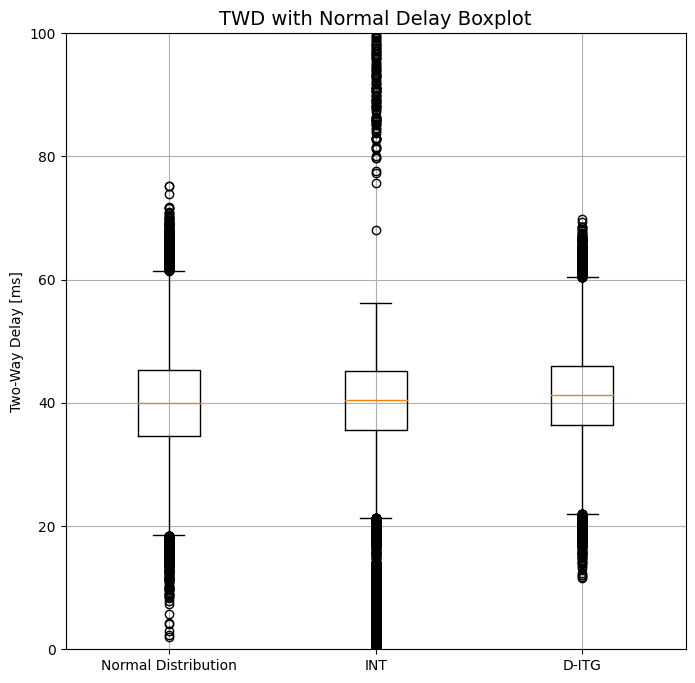

1076
5554
969


In [ ]:
data_folder = "/content/drive/MyDrive/Colab_Notebooks/Thesis/Data/NormalDelay/"

# Load data from JSON files
normal_int_twd = load_int_file(data_folder+"int_from_ping_twd_records.json", 0, 100)
#normal_itg_twd = load_itg_file(data_folder+"itg_twd_records.json", 28, 200)
normal_ping_twd = load_ping_records(data_folder+'ping_twd_records.txt', 0, 100)

print(len(normal_int_twd),  len(normal_ping_twd))

avg_to_append = np.mean(normal_int_twd)
for i in range(144000-len(normal_int_twd)):
  normal_int_twd.append(avg_to_append)
# avg_to_append = np.mean(normal_itg_twd)
# for i in range(144000-len(normal_itg_twd)):
#   normal_itg_twd.append(avg_to_append)
avg_to_append = np.mean(normal_ping_twd)
for i in range(144000-len(normal_ping_twd)):
  normal_ping_twd.append(avg_to_append)

print(len(normal_int_twd), len(normal_ping_twd))  #len(normal_itg_twd), )

data = np.random.normal(loc=40, scale=8, size=len(normal_int_twd))
datasets = [data, normal_int_twd, normal_ping_twd]
limits = [0, 100]   #[np.min(datasets)-0.1, np.max(datasets)+0.1]
labels = ["Normal Distribution", "INT", "D-ITG"]
gen_boxplot(datasets, labels, limits, "Two-Way Delay [ms]", "TWD with Normal Delay Boxplot", data_folder+"Plots/boxplot_twd_normal.png")
for data in datasets:
  print(count_outliers(data))


Extract Statistics from Datasets and generate plots

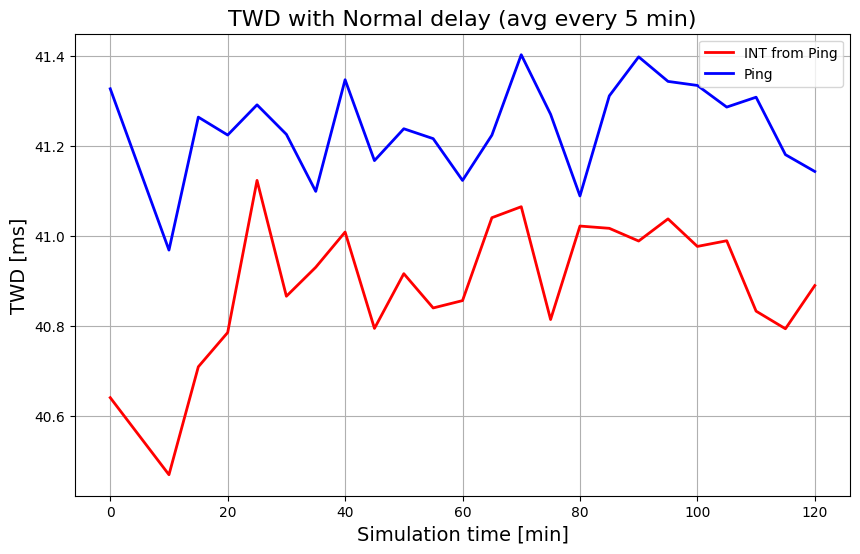

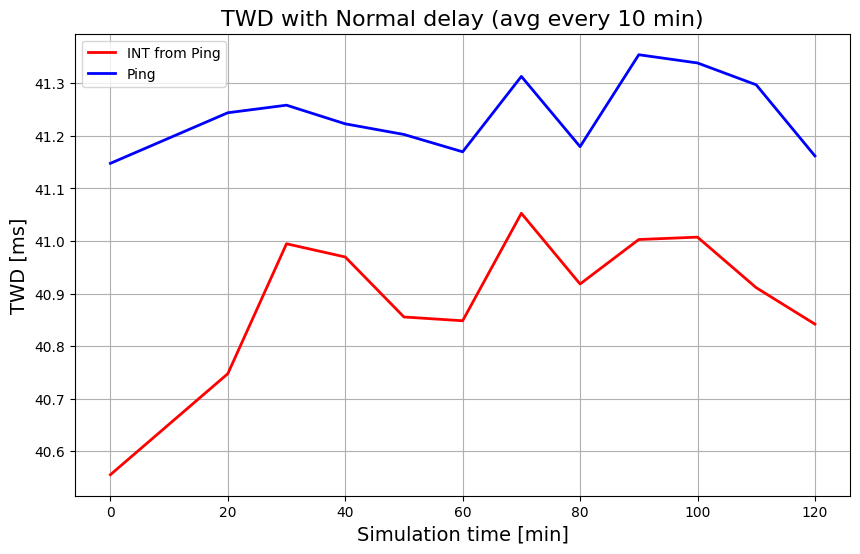

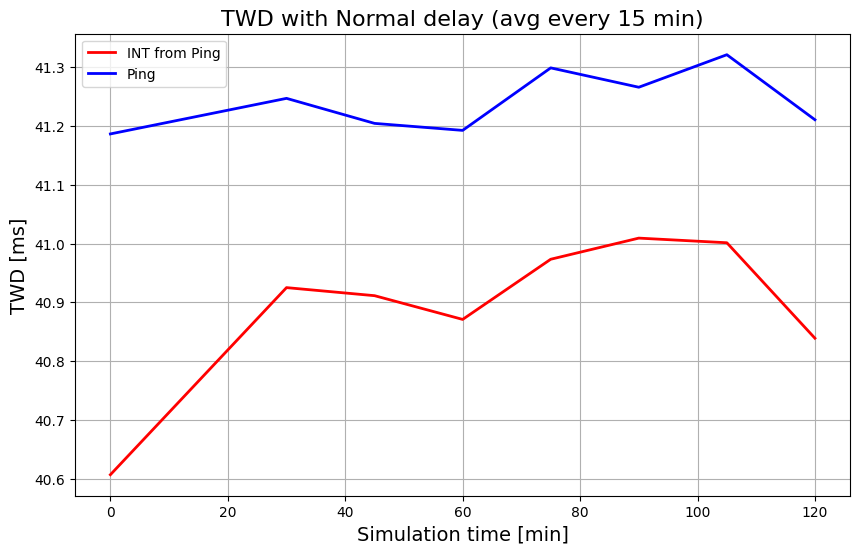

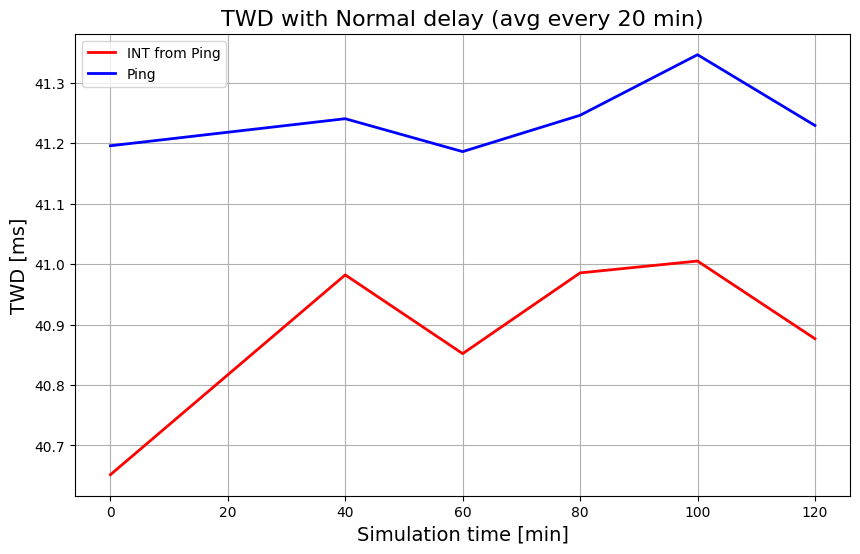

In [ ]:
sim_time_range = [5, 10, 15, 20]
for i in sim_time_range:
  sample_size = 20*60*i
  total_min = 120
  packet_rate = len(normal_int_twd)/(total_min*60)
  pack_to_time_factor = sample_size/packet_rate


  # Load data and compute statistics
  df_normal_int_twd = extract_stats(normal_int_twd, sample_size)
  #df_normal_itg_twd = extract_stats(normal_itg_twd, sample_size)
  df_normal_ping_twd = extract_stats(normal_ping_twd, sample_size)

  time_seconds = np.array((df_normal_int_twd.index + 1) * pack_to_time_factor/60)
  time_seconds[0] = 0

  # Print DataFrames
  # print("INT Data Statistics:")
  # print(df_normal_int_twd)
  # print("\nITG Data Statistics:")
  # print(df_normal_itg_twd)
  # print("\nPing Data Statistics:")
  # print(df_normal_ping_twd)

  datasets = [df_normal_int_twd["Average"], df_normal_ping_twd["Average"]]
  labels = ["INT from Ping", "Ping"]
  colors = ["red", "blue"]

  import_data = pd.DataFrame({
      "INT": df_normal_int_twd["Average"],
      "ITG": df_normal_ping_twd["Average"],
  })
  import_data.to_csv(data_folder+"Excel_Import/twd_normal_"+str(i)+"min.csv")

  plot_curves_new(datasets=datasets, x_axys=time_seconds, filename=data_folder+"Plots/twd_normal"+str(i)+"min.png", labels=labels, colors=colors, title='TWD with Normal delay (avg every '+str(i)+' min)')


## Sinusoidal Delay

Load Two-Way Delay Datasets from files

In [ ]:
data_folder = "/content/drive/MyDrive/Colab_Notebooks/Thesis/Data/SinusoidalDelay/"

# Load data from JSON files
sin_int_twd = load_int_file(data_folder+"int_twd_records.json", 0, 200)
sin_itg_twd = load_itg_file(data_folder+"itg_twd_records.json", 0, 200)
sin_ping_twd = load_ping_records(data_folder+'ping_twd_records.txt', 0, 200)

avg_to_append = np.mean(sin_int_twd)
for i in range(72000-len(sin_int_twd)):
  sin_int_twd.append(avg_to_append)
avg_to_append = np.mean(sin_itg_twd)
for i in range(72000-len(sin_itg_twd)):
  sin_itg_twd.append(avg_to_append)
avg_to_append = np.mean(sin_ping_twd)
for i in range(72000-len(sin_ping_twd)):
  sin_ping_twd.append(avg_to_append)

print(len(sin_int_twd), len(sin_ping_twd), len(sin_itg_twd))

72000 72000 72000


Extract Statistics from Datasets and generate plots

,Groundtruth,INT,ITG,OWPing
0,20,21.238060,21.488395,21.264667
1,20,21.251661,21.507840,21.276500
2,20,21.235040,21.492580,21.259167
3,20,21.223813,21.501272,21.248500
4,20,21.241205,21.455673,21.263167
...,...,...,...,...
115,20,21.214196,21.484628,21.238833
116,20,21.182871,21.474432,21.214667
117,20,21.197096,21.416552,21.225333
118,20,21.198244,21.450217,21.226333


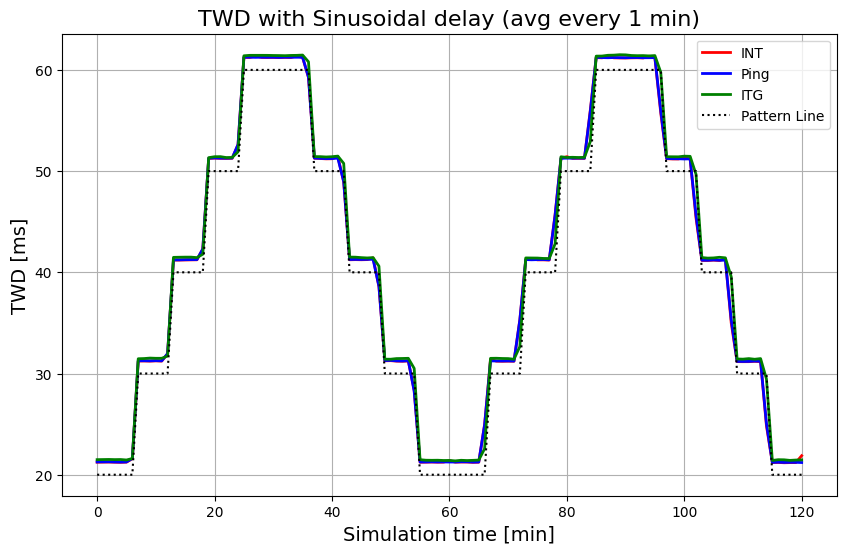

In [ ]:
sim_time_range = [1]
for i in sim_time_range:
  sample_size = 10*60*i
  total_min = 120
  packet_rate = len(sin_int_twd)/(total_min*60)
  pack_to_time_factor = sample_size/packet_rate


  # Load data and compute statistics
  df_sin_int_twd = extract_stats(sin_int_twd, sample_size)
  df_sin_itg_twd = extract_stats(sin_itg_twd, sample_size)
  df_sin_ping_twd = extract_stats(sin_ping_twd, sample_size)

  time_seconds = np.array((df_sin_int_twd.index + 1) * pack_to_time_factor/60)
  time_seconds[0] = 0

  pattern = [20, 30, 40, 50, 60, 60, 50, 40, 30, 20]
  pattern_length = len(pattern)
  dotted_line = [value for value in pattern for _ in range(6)]
  dotted_line = dotted_line * (len(time_seconds) // len(dotted_line)) + dotted_line[:len(time_seconds) % len(dotted_line)]

  datasets = [df_sin_int_twd["Average"], df_sin_ping_twd["Average"], df_sin_itg_twd["Average"]]
  labels = ["INT", "Ping", "ITG"]
  colors = ["red", "blue", "green"]

  import_data = pd.DataFrame({
      "Groundtruth": dotted_line,
      "INT": df_sin_int_twd["Average"],
      "ITG": df_sin_itg_twd["Average"],
      "OWPing": df_sin_ping_twd["Average"]
  })
  display(import_data)
  #import_data.to_csv(data_folder+"Excel_Import/twd_sin_"+str(i)+"min.csv")

  plot_curves_new(datasets=datasets, x_axys=time_seconds, filename=data_folder+"Plots/twd_sin_"+str(i)+"min.png", labels=labels, colors=colors, title='TWD with Sinusoidal delay (avg every '+str(i)+' min)', sinusoidal=True, n=6)


# Packet Loss Tests

### Fixed Delay

Calculate the lost packet in ITG and INT

In [ ]:
folder = "/content/drive/MyDrive/Colab_Notebooks/Thesis/Data/PacketLoss/FixedDelay/"
file_path = folder+'test_loss.txt'

itg_lost_packets = extract_sequence_numbers(file_path)
int_lost_packets = load_lost_packets_file(folder+"packet_lost.json")
print(len(itg_lost_packets), len(int_lost_packets))
# itg_lost_packets = np.append(itg_lost_packets, int_lost_packets[-1])  # itg has always 1 sample less than int

# lost_packets = pd.DataFrame({'INT':int_lost_packets, 'ITG':itg_lost_packets})
# lost_packets

605 606


Load 60000 samples of OWD: INT and D-ITG

In [ ]:
int_loss_owd = load_int_file(folder+"int_AtoB_owd_records.json", 0, 20)
itg_loss_owd = load_itg_file(folder+"itg_owd_loss.json", 0, 20)
print(len(int_loss_owd), len(itg_loss_owd))

avg_to_append = np.mean(int_loss_owd)
for i in range(60000-len(int_loss_owd)):
  int_loss_owd.append(avg_to_append)
avg_to_append = np.mean(itg_loss_owd)
for i in range(60000-len(itg_loss_owd)):
  itg_loss_owd.append(avg_to_append)

print("OWD number of samples for INT and D-ITG:", len(int_loss_owd), len(itg_loss_owd))

sim_time_range = [5000]
for i in sim_time_range:
  sample_size = i
  total_min = 60
  packet_rate = len(int_loss_owd)/(total_min*60)
  pack_to_time_factor = sample_size/packet_rate


  # Load data and compute statistics
  df_int_loss_owd = extract_stats(int_loss_owd, sample_size)
  df_itg_loss_owd = extract_stats(itg_loss_owd, sample_size)

  time_seconds = np.array((df_int_loss_owd.index + 1) * pack_to_time_factor/60)
  time_seconds[0] = 0

  datasets = [df_int_loss_owd["Average"], df_itg_loss_owd["Average"]]
  labels = ["INT", "ITG"]
  colors = ["red", "blue"]

  #plot_curves_new(datasets=datasets, x_axys=time_seconds, filename="owd_AtoB_normal_"+str(i)+"min.png", labels=labels, colors=colors, title='OWD A->B with normal delay (avg every '+str(i)+' min)')

  owd_data = pd.DataFrame({
      'ITG_OWD': df_int_loss_owd["Average"],
      'INT_OWD': df_itg_loss_owd["Average"]
  })


  # Count the lost packets in segments for both ITG and INT data
  int_segment_counts = count_lost_packets_in_segments(lost_packets["INT"], 60000, i)
  itg_segment_counts = count_lost_packets_in_segments(lost_packets["ITG"], 60000, i)

  # Prepare the data for plotting
  export_data = pd.DataFrame({
      'ITG OWD': df_itg_loss_owd["Average"],
      'INT OWD': df_int_loss_owd["Average"],
      'ITG Lost Packets': itg_segment_counts,
      'INT Lost Packets': int_segment_counts
  })

  export_data.to_csv(folder+'OWD_Fixed_'+str(int(60/(60000/i)))+'min.csv')
  display(export_data)


58039 59380
OWD number of samples for INT and D-ITG: 60000 60000


,ITG OWD,INT OWD,ITG Lost Packets,INT Lost Packets
0,15.674552,15.398373,49,49
1,15.659171,15.366586,47,48
2,15.700759,15.407897,49,49
3,15.648824,15.401124,38,38
4,15.663435,15.354719,60,60
5,15.671360,15.356557,54,54
6,15.690678,15.418348,47,47
7,15.758780,15.469996,49,49
8,15.743525,15.431507,57,57
9,15.694448,15.389590,49,49


from matplotlib import pyplot as plt
export_data['ITG OWD'].plot(kind='hist', bins=20, title='ITG OWD')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
export_data['INT OWD'].plot(kind='hist', bins=20, title='INT OWD')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
export_data['ITG Lost Packets'].plot(kind='hist', bins=20, title='ITG Lost Packets')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
export_data['INT Lost Packets'].plot(kind='hist', bins=20, title='INT Lost Packets')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
export_data.plot(kind='scatter', x='ITG OWD', y='INT OWD', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
export_data.plot(kind='scatter', x='INT OWD', y='ITG Lost Packets', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
export_data.plot(kind='scatter', x='ITG Lost Packets', y='INT Lost Packets', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
export_data['ITG OWD'].plot(kind='line', figsize=(8, 4), title='ITG OWD')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
export_data['INT OWD'].plot(kind='line', figsize=(8, 4), title='INT OWD')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
export_data['ITG Lost Packets'].plot(kind='line', figsize=(8, 4), title='ITG Lost Packets')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
export_data['INT Lost Packets'].plot(kind='line', figsize=(8, 4), title='INT Lost Packets')
plt.gca().spines[['top', 'right']].set_visible(False)

### Normal Delay

Calculate the lost packet in ITG and INT

In [ ]:
folder = "/content/drive/MyDrive/Colab_Notebooks/Thesis/Data/PacketLoss/NormalDelay/"
file_path = folder+'test_loss.txt'

itg_lost_packets = extract_sequence_numbers(file_path)
int_lost_packets = load_lost_packets_file(folder+"packet_lost.json")
diff = len(int_lost_packets) - len(itg_lost_packets)

# itg_lost_packets = np.append(itg_lost_packets, int_lost_packets[-diff:])  # fill the last itg samples with int samples

# print(len(int_lost_packets), len(itg_lost_packets))

# lost_packets = pd.DataFrame({'INT':int_lost_packets, 'ITG':itg_lost_packets})
# lost_packets

Load 60000 samples of OWD: INT and D-ITG

In [ ]:
int_loss_owd = load_int_file(folder+"int_AtoB_owd_records.json", 0, 50)
itg_loss_owd = load_itg_file(folder+"itg_owd_loss.json", 0, 50)
print(len(int_loss_owd), len(itg_loss_owd))

avg_to_append = np.mean(int_loss_owd)
for i in range(60000-len(int_loss_owd)):
  int_loss_owd.append(avg_to_append)
avg_to_append = np.mean(itg_loss_owd)
for i in range(60000-len(itg_loss_owd)):
  itg_loss_owd.append(avg_to_append)

print("OWD number of samples for INT and D-ITG:", len(int_loss_owd), len(itg_loss_owd))

sim_time_range = [5000]
for i in sim_time_range:
  sample_size = i
  total_min = 60
  packet_rate = len(int_loss_owd)/(total_min*60)
  pack_to_time_factor = sample_size/packet_rate


  # Load data and compute statistics
  df_int_loss_owd = extract_stats(int_loss_owd, sample_size)
  df_itg_loss_owd = extract_stats(itg_loss_owd, sample_size)

  time_seconds = np.array((df_int_loss_owd.index + 1) * pack_to_time_factor/60)
  time_seconds[0] = 0

  datasets = [df_int_loss_owd["Average"], df_itg_loss_owd["Average"]]
  labels = ["INT", "ITG"]
  colors = ["red", "blue"]

  #plot_curves_new(datasets=datasets, x_axys=time_seconds, filename="owd_AtoB_normal_"+str(i)+"min.png", labels=labels, colors=colors, title='OWD A->B with normal delay (avg every '+str(i)+' min)')

  owd_data = pd.DataFrame({
      'ITG_OWD': df_int_loss_owd["Average"],
      'INT_OWD': df_itg_loss_owd["Average"]
  })


  # Count the lost packets in segments for both ITG and INT data
  int_segment_counts = count_lost_packets_in_segments(int_lost_packets, 60000, i)
  itg_segment_counts = count_lost_packets_in_segments(itg_lost_packets, 60000, i)

  # Prepare the data for plotting
  export_data = pd.DataFrame({
      'ITG OWD': df_itg_loss_owd["Average"],
      'INT OWD': df_int_loss_owd["Average"],
      'ITG Lost Packets': itg_segment_counts,
      'INT Lost Packets': int_segment_counts
  })

  export_data.to_csv(folder+'OWD_Normal_'+str(int(60/(60000/i)))+'min.csv')
  display(export_data)


59825 59420
OWD number of samples for INT and D-ITG: 60000 60000


,ITG OWD,INT OWD,ITG Lost Packets,INT Lost Packets
0,25.762025,25.351200,49,51
1,25.622007,25.249649,44,44
2,25.582948,25.175382,53,56
3,25.612615,25.210497,46,44
4,25.607490,25.231059,47,48
5,25.661074,25.319345,46,47
6,25.755263,25.342983,51,54
7,25.589233,25.227638,41,41
8,25.848583,25.443954,47,47
9,25.752465,25.292258,51,54


### Sinusoidal Delay

Calculate the lost packet in ITG and INT

In [ ]:
folder = "/content/drive/MyDrive/Colab_Notebooks/Thesis/Data/PacketLoss/SinusoidalDelay/"
file_path = folder+'test_loss.txt'

itg_lost_packets = extract_sequence_numbers(file_path)
int_lost_packets = load_lost_packets_file(folder+"packet_lost.json")
diff = len(int_lost_packets) - len(itg_lost_packets)
print(diff)
itg_lost_packets = np.append(itg_lost_packets, int_lost_packets[-diff:])  # fill the last itg samples with int samples

print(len(int_lost_packets), len(itg_lost_packets))

lost_packets = pd.DataFrame({'INT':int_lost_packets, 'ITG':itg_lost_packets})
lost_packets

1
582 582


,INT,ITG
0,50,45
1,164,159
2,221,216
3,232,227
4,238,233
...,...,...
577,59747,59711
578,59841,59805
579,59879,59843
580,59995,59958


Load 60000 samples of OWD: INT and D-ITG

In [ ]:
int_loss_owd = load_int_file(folder+"int_AtoB_owd_records.json", 0, 50)
itg_loss_owd = load_itg_file(folder+"itg_owd_loss.json", 0, 50)
print(len(int_loss_owd), len(itg_loss_owd))

avg_to_append = np.mean(int_loss_owd)
for i in range(60000-len(int_loss_owd)):
  int_loss_owd.append(avg_to_append)
avg_to_append = np.mean(itg_loss_owd)
for i in range(60000-len(itg_loss_owd)):
  itg_loss_owd.append(avg_to_append)

print("OWD number of samples for INT and D-ITG:", len(int_loss_owd), len(itg_loss_owd))

sim_time_range = [1000]
for i in sim_time_range:
  sample_size = i
  total_min = 60
  packet_rate = len(int_loss_owd)/(total_min*60)
  pack_to_time_factor = sample_size/packet_rate


  # Load data and compute statistics
  df_int_loss_owd = extract_stats(int_loss_owd, sample_size)
  df_itg_loss_owd = extract_stats(itg_loss_owd, sample_size)

  time_seconds = np.array((df_int_loss_owd.index + 1) * pack_to_time_factor/60)
  time_seconds[0] = 0

  datasets = [df_int_loss_owd["Average"], df_itg_loss_owd["Average"]]
  labels = ["INT", "ITG"]
  colors = ["red", "blue"]

  #plot_curves_new(datasets=datasets, x_axys=time_seconds, filename="owd_AtoB_normal_"+str(i)+"min.png", labels=labels, colors=colors, title='OWD A->B with normal delay (avg every '+str(i)+' min)')

  owd_data = pd.DataFrame({
      'ITG_OWD': df_int_loss_owd["Average"],
      'INT_OWD': df_itg_loss_owd["Average"]
  })

  # Count the lost packets in segments for both ITG and INT data
  int_segment_counts = count_lost_packets_in_segments(lost_packets["INT"], 60000, i)
  itg_segment_counts = count_lost_packets_in_segments(lost_packets["ITG"], 60000, i)

  pattern = [10, 15, 20, 25, 30, 30, 25, 20, 15, 10]
  pattern_length = len(pattern)
  n = int(len(int_segment_counts)/len(pattern))
  gt = [value for value in pattern for _ in range(n)]

  # Prepare the data for plotting
  export_data = pd.DataFrame({
      'GroundTruth': gt,
      'ITG OWD': df_itg_loss_owd["Average"],
      'INT OWD': df_int_loss_owd["Average"],
      'ITG Lost Packets': itg_segment_counts,
      'INT Lost Packets': int_segment_counts
  })

  export_data.to_csv(folder+'OWD_Sinusoidal_'+str(int(60/(60000/i)))+'min.csv')
  display(export_data)


58847 59409
OWD number of samples for INT and D-ITG: 60000 60000


,GroundTruth,ITG OWD,INT OWD,ITG Lost Packets,INT Lost Packets
0,10,10.514322,10.315752,8,8
1,10,10.559606,10.407836,7,7
2,10,10.769100,10.522951,12,12
3,10,10.741850,10.536514,9,9
4,10,10.715934,10.584735,5,5
5,10,11.269169,10.970738,9,9
6,15,15.762370,15.540543,7,7
7,15,15.701047,15.450729,7,6
8,15,15.697312,15.425304,12,12
9,15,15.721449,15.500233,5,6


# GroundTruth Stats


## Fixed Delay

In [ ]:
gt = np.array([20]*len(fixed_int_owd_ab))
columns = ["INT Mean", "INT std", "ITG Mean", "ITG std", "OWPing Mean", "OWPing std"]
df = pd.DataFrame(columns=columns)

df.loc[0, 'INT Mean'], df.loc[0, 'INT std'] = get_difference_mean(fixed_int_owd_ab, gt)
df.loc[0, 'ITG Mean'], df.loc[0, 'ITG std'] = get_difference_mean(fixed_itg_owd_ab, gt)
df.loc[0, 'OWPing Mean'], df.loc[0, 'OWPing std'] = get_difference_mean(fixed_owping_owd_ab, gt)

gt = np.array([20]*len(fix_int_owd_ba))
columns = ["INT Mean", "INT std", "ITG Mean", "ITG std", "OWPing Mean", "OWPing std"]

df.loc[1, 'INT Mean'], df.loc[1, 'INT std'] = get_difference_mean(fix_int_owd_ba, gt)
df.loc[1, 'ITG Mean'], df.loc[1, 'ITG std'] = get_difference_mean(fix_itg_owd_ba, gt)
df.loc[1, 'OWPing Mean'], df.loc[1, 'OWPing std'] = get_difference_mean(fix_owping_owd_ba, gt)

gt = np.array([40]*len(fixed_int_twd))

df.loc[2, 'INT Mean'], df.loc[2, 'INT std'] = get_difference_mean(fixed_int_twd, gt)
df.loc[2, 'ITG Mean'], df.loc[2, 'ITG std'] = get_difference_mean(fixed_itg_twd, gt)
df.loc[2, 'OWPing Mean'], df.loc[2, 'OWPing std'] = get_difference_mean(fixed_ping_twd, gt)

display(df)

,INT Mean,INT std,ITG Mean,ITG std,OWPing Mean,OWPing std
0,0.61336,0.09482,0.77673,0.08048,-0.48362,0.17307
1,0.57326,0.21674,0.7268,0.2415,1.79092,0.1874
2,1.40157,0.11028,1.57181,0.29351,1.09444,0.08831


## Sinusoidal Delay


Get the Mean and Variance of the difference between 3 curves (INT, D-ITG-(OW)Ping) and the groundtruth (delay pattern)

In [ ]:
# OWD: CPE-A -> CPE-B
pattern = [10, 15, 20, 25, 30, 30, 25, 20, 15, 10]
pattern_length = len(pattern)
n = int(len(sin_int_owd_ab)/len(pattern)/6)
gt = [value for value in pattern for _ in range(n)]
gt = np.tile(gt, 6)
columns = ["INT Mean", "INT std", "ITG Mean", "ITG std", "OWPing Mean", "OWPing std"]
df = pd.DataFrame(columns=columns)

df.loc[0, 'INT Mean'], df.loc[0, 'INT std'] = get_difference_mean(sin_int_owd_ab, gt)
df.loc[0, 'ITG Mean'], df.loc[0, 'ITG std'] = get_difference_mean(sin_itg_owd_ab, gt)
df.loc[0, 'OWPing Mean'], df.loc[0, 'OWPing std'] = get_difference_mean(sin_owping_owd_ab, gt)

# OWD: CPE-B -> CPE-A
n = int(len(sin_int_owd_ba)/len(pattern))
gt = [value for value in pattern for _ in range(n)]
df.loc[1, 'INT Mean'], df.loc[1, 'INT std'] = get_difference_mean(sin_int_owd_ba, gt)
df.loc[1, 'ITG Mean'], df.loc[1, 'ITG std'] = get_difference_mean(sin_itg_owd_ba, gt)
df.loc[1, 'OWPing Mean'], df.loc[1, 'OWPing std'] = get_difference_mean(sin_owping_owd_ba, gt)


# TWD
pattern = np.array(pattern)*2
pattern_length = len(pattern)
n = int(len(sin_int_twd)/len(pattern)/2)
gt = [value for value in pattern for _ in range(n)]
gt = np.tile(gt, 2)
print(len(gt))

df.loc[2, 'INT Mean'], df.loc[2, 'INT std'] = get_difference_mean(sin_int_twd, gt)
df.loc[2, 'ITG Mean'], df.loc[2, 'ITG std'] = get_difference_mean(sin_itg_twd, gt)
df.loc[2, 'OWPing Mean'], df.loc[2, 'OWPing std'] = get_difference_mean(sin_ping_twd, gt)

display(df)

72000


,INT Mean,INT std,ITG Mean,ITG std,OWPing Mean,OWPing std
0,0.4524,3.10975,0.65223,3.10913,1.24883,1.6791
1,0.46356,1.87233,0.61964,1.28787,-0.0222,0.97271
2,1.13563,2.57446,1.40502,1.19929,1.14093,2.105
